<a href="https://colab.research.google.com/github/jamiroquai1225/Anomaly-Detection/blob/main/anomaly_detection_of_the_time_series_data_in_jeju_seaport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

In [3]:
data = '/content/drive/MyDrive/논문/항만 물동량 이상치 탐지 : anomaly detection의 적용/data/port.xlsx'

In [7]:
data_df = pd.read_excel(data)
data_df

,time,cargo
0,2000-01,41357
1,2000-02,48615
2,2000-03,41036
3,2000-04,33452
4,2000-05,36137
...,...,...
279,2023-04,1564123
280,2023-05,1513617
281,2023-06,1470733
282,2023-07,1373600


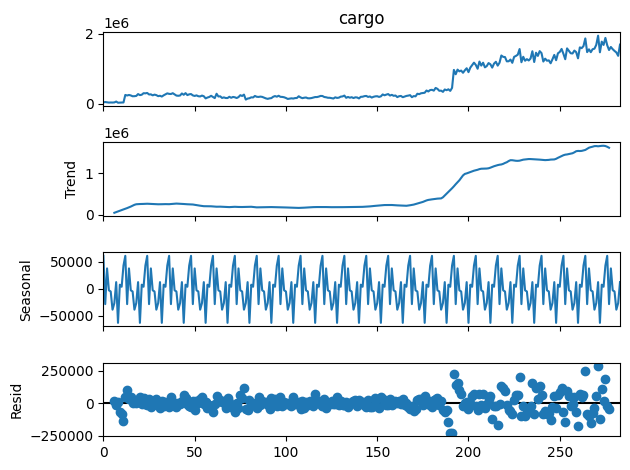

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Perform additive decomposition
decomp = seasonal_decompose(data_df['cargo'], period=12)

# Plot decomposition
decomp.plot();
plt.tight_layout();

# 시계열 이상치 탐지 ver.1

In [10]:
data_df.loc[:,'time'] = pd.to_datetime(data_df.time)

<ipython-input-10-8c5d9a866fd5>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_df.loc[:,'time'] = pd.to_datetime(data_df.time)


In [ ]:
data_df

In [ ]:
data_df.isna().sum()

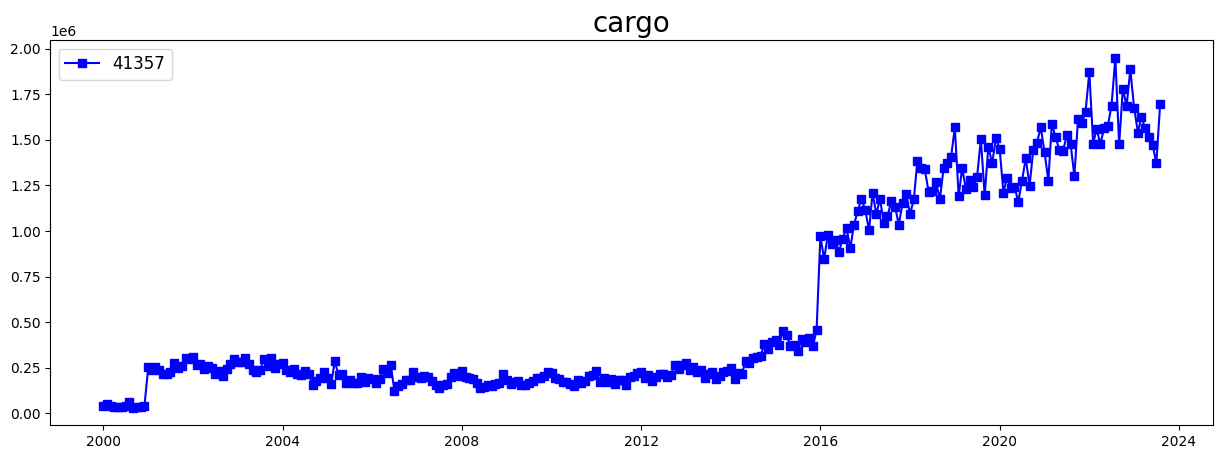

In [ ]:
from matplotlib.pylab import rcParams
plt.rcParams["figure.figsize"] = (15,5)
plt.title('cargo', fontsize=20)
plt.plot(data_df.time, data_df.cargo, marker='s', color='b')
plt.legend(data_df['cargo'], fontsize=12, loc='best')

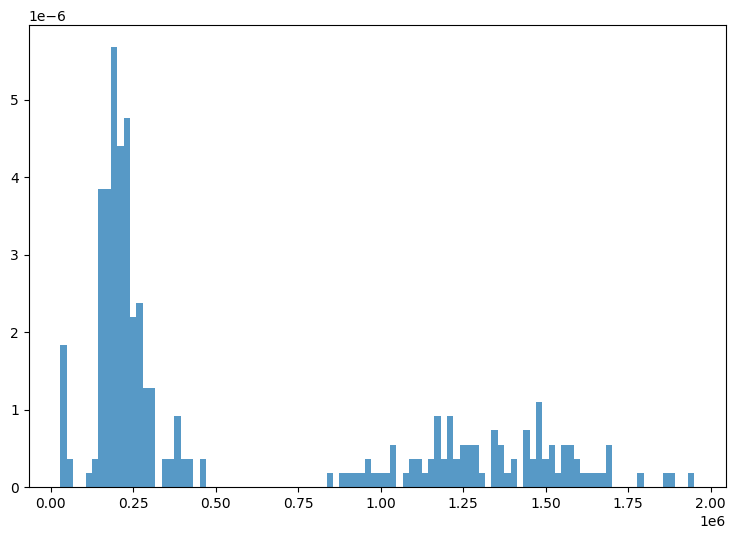

In [ ]:
# 해결 - Unsupervised z-test
# 데이터가 정규분포를 따르는지 확인
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(data_df.cargo, 100, density=True, alpha=0.75)

In [ ]:
from statsmodels.stats.weightstats import ztest
r = result.resid.values
st, p = ztest(r)
print(st,p)

-0.3239493338126083 0.7459763931713185


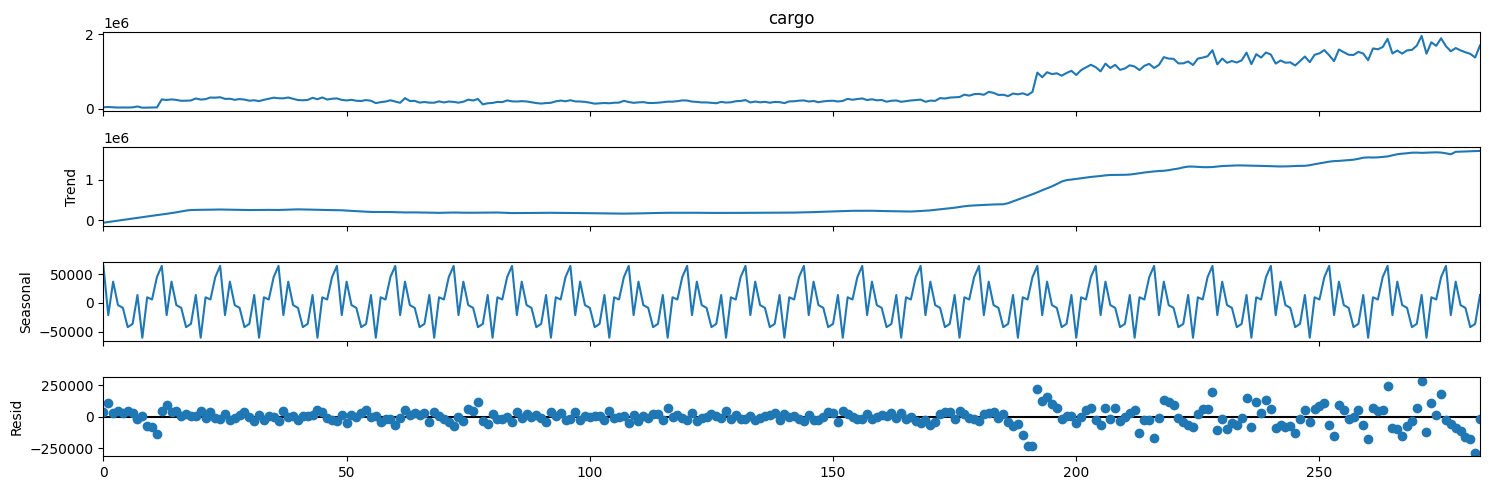

In [ ]:
# Time series decomposition 시계열 데이터 중에서 정규분포에 가까운 데이터를 뽑아내는 방법

# additive 방법

from statsmodels.tsa.seasonal import seasonal_decompose

# 계절적 성분 50일로 가정
# extrapolate_trend='freq' : Trend 성분을 만들기 위한 rolling window 때문에 필연적으로 trend, resid에는 Nan 값이 발생하기 때문에, 이 NaN값을 채워주는 옵션
result = seasonal_decompose(data_df.cargo, model='additive', two_sided=True,
                            period=12, extrapolate_trend='freq')
result.plot()
plt.show()

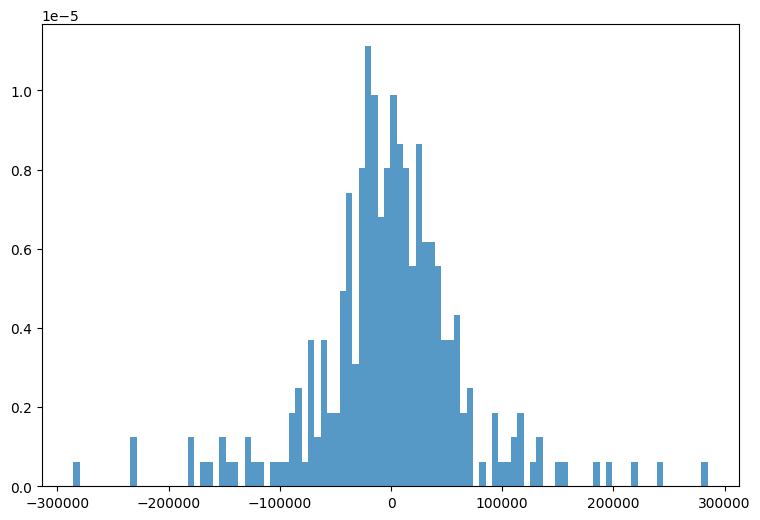

In [ ]:
# Residual의 분포 확인
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [ ]:
# z-test를 통해 숫자로 다시 확인
# p-value가 0.05이상으로 나오면, 데이터 분포가 정규분포를 잘 따르고 있음
r = result.resid.values
st, p = ztest(r)
print(st,p)  # -0.6804023554131796 0.4962497300226193

-0.3239493338126083 0.7459763931713185


In [ ]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)
# 평균: -0.3595321143716522 표준편차: 39.8661527194307

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))
# 이상치 갯수: 71
data_df.time[result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

평균: -1305.2147644399204 표준편차: 67899.10608486531
이상치 갯수: 6


190   2015-11-01
191   2015-12-01
192   2016-01-01
264   2022-01-01
271   2022-08-01
282   2023-07-01
Name: time, dtype: datetime64[ns]

In [ ]:
# Multi-variable Anomaly Detection - Clustering
# 데이터 전처리
def my_decompose(data_df, features, freq=12):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()

    # 사용할 feature 마다 decompose를 수행한다.
    for f in features:
        result = seasonal_decompose(data_df[f], model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values

    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(data_df, features=['cargo'])
tdf.describe()

,cargo
count,2.840000e+02
mean,5.806179e+05
std,5.471934e+05
min,-5.733346e+04
25%,1.873937e+05
50%,2.524854e+05
75%,1.141287e+06
max,1.718465e+06


In [ ]:
rdf.describe()

,cargo
count,284.000000
mean,-1580.759371
std,68555.518740
min,-301659.768491
25%,-29674.185167
50%,-93.105555
75%,31371.579437
max,285128.936151


In [ ]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
# [-0.40184982  -0.38035856  -0.39874878  -0.37402025 -195.40645742]

norm_rdf = scaler.transform(rdf)

In [ ]:
# clustering : k-means로 이상치 탐지
# k-means를 이용해서 정상 데이터그룹과 이상치 데이터 그룹을 분류함
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인
# [1 1 1 ... 0 0 0]


# 라벨은 몇번 그룹인지 뜻한다.
# return_counts=True : 몇개의 샘플이 몇번 그룹에 할당되었는지 확인
lbl, cnt = np.unique(kmeans.labels_,return_counts=True)
print(lbl) # [0 1]  -> 0번 그룹, 1번 그룹으로 나뉨
print(cnt) # [3258 2434]  -> 0번그룹에 3258, 1번그룹에 2434

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

In [ ]:
# 이상치 날짜 탐색
data_df[(kmeans.labels_==2)|(kmeans.labels_==8)|(kmeans.labels_==11)]

In [ ]:
data_df.describe()

,cargo
count,2.840000e+02
mean,5.790365e+05
std,5.471714e+05
min,2.938700e+04
25%,1.940888e+05
50%,2.464365e+05
75%,1.161358e+06
max,1.950943e+06


In [ ]:
# 각 그룹별 특징
pd.DataFrame(kmeans.cluster_centers_, columns=['cargo'])

,cargo
0,0.464663
1,-0.885858
2,3.883281
3,-2.606863
4,1.548892
5,-0.196812
6,0.115536
7,-1.317686
8,-3.352715
9,2.070618


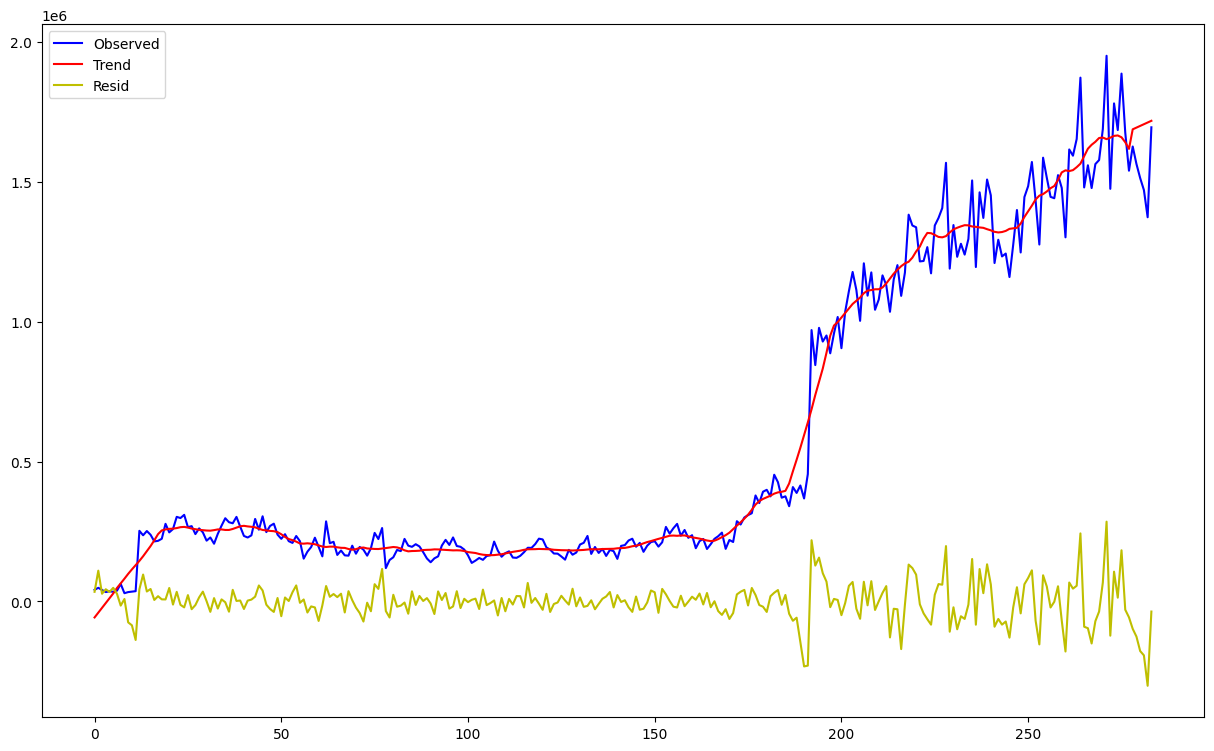

In [ ]:
# 파랑 : 실제 화물량, 빨갱 : 트렌드, 노랑: 잔차
# 잔차 등락에 따라 이상치를 탐색함
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
data_df.cargo.plot(ax=ax, label='Observed', legend=True, color='b')
tdf.cargo.plot(ax=ax, label='Trend', legend=True, color='r')
rdf.cargo.plot(ax=ax,label='Resid', legend=True, color='y')
plt.show()

In [ ]:
# clustering : DBSCAN으로 이상치 탐지
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
print(clustering)  # BSCAN(eps=0.7, min_samples=2)
print(clustering.labels_)  # [0 0 0 ... 0 0 0]

lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

DBSCAN(eps=0.7, min_samples=2)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]


['group:-1-count:1', 'group:0-count:283']

# Auto encoder

In [ ]:
# LSTM 을 이용한 오토인코더 모델 만들기
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler

In [ ]:
# 모델 재현성을 위해 난수 시드설정
tf.random.set_seed(777)
np.random.seed(777)

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['cargo']
n_features = len(features)
TRAIN_SIZE = int(len(data_df)*0.7)

# 데이터 전처리 - 표준정규분포화
scaler = StandardScaler()
scaler = scaler.fit(data_df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(data_df[features].values)

# keras TimeseriesGenerator를 이용해 데이터셋 만들기
train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)  # (32, 10, 5)
print(train_gen[0][1].shape)  # (32, 5)


# 모델만들기
# 2개 층의 LSTM으로 인코더 만듬
# RepeatVector는 input을 window_size만큼 복사해줌
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])


# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장함
checkpoint_path = os.getenv('HOME')+'/content/drive/MyDrive/논문/항만 물동량 이상치 탐지 : anomaly detection의 적용/'
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜봄
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])


hist = model.fit(train_gen,
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50,
          callbacks=[checkpoint, early_stop])


model.load_weights(checkpoint_path)

(32, 10, 1)
(32, 1)
Epoch 1/50
7/9 [======================>.......] - ETA: 0s - loss: 1.3013 - mae: 1.3013
Epoch 1: val_loss improved from inf to 7.47889, saving model to /root/content/drive/MyDrive/논문/항만 물동량 이상치 탐지 : anomaly detection의 적용/
9/9 [==============================] - 7s 137ms/step - loss: 2.6256 - mae: 2.6256 - val_loss: 7.4789 - val_mae: 7.4789
Epoch 2/50
8/9 [=========================>....] - ETA: 0s - loss: 2.1207 - mae: 2.1207
Epoch 2: val_loss improved from 7.47889 to 6.04571, saving model to /root/content/drive/MyDrive/논문/항만 물동량 이상치 탐지 : anomaly detection의 적용/
9/9 [==============================] - 1s 55ms/step - loss: 2.4339 - mae: 2.4339 - val_loss: 6.0457 - val_mae: 6.0457
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 1.8691 - mae: 1.8691
Epoch 3: val_loss improved from 6.04571 to 3.95168, saving model to /root/content/drive/MyDrive/논문/항만 물동량 이상치 탐지 : anomaly detection의 저

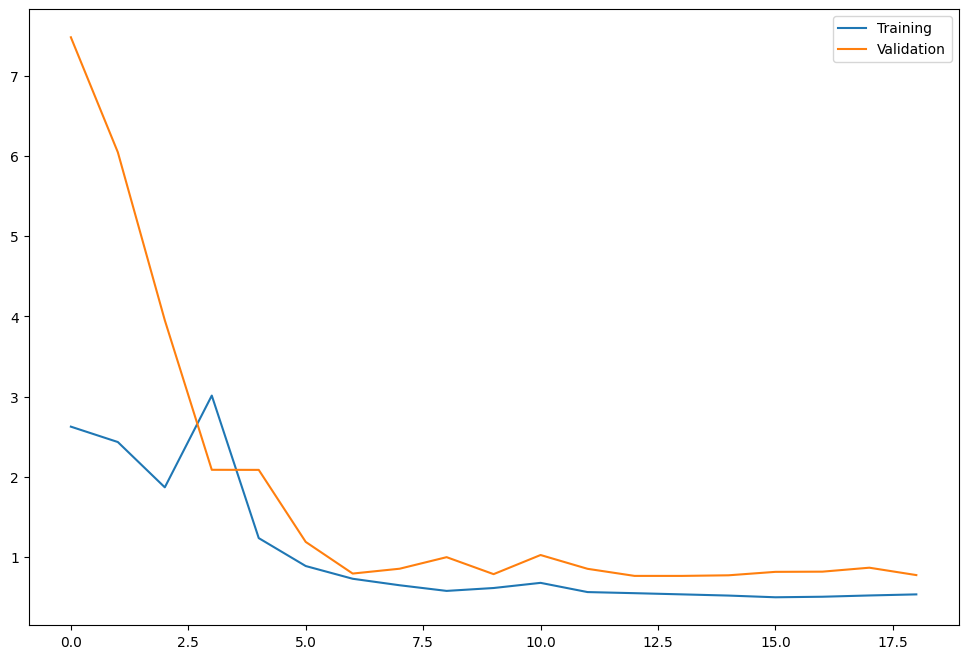

In [ ]:
# 안정적으로 Training loss 가 수렴하고 Validation loss 가 발산하지 않음을 확인
# 시계열 데이터를 window_size 만큼 밀어가면서 예측하는 모델이라 train_gen의 길이는 원본 df의 길이보다 window_size만큼 짧음
# 예측 결과와 비교할 때는 scaled의 앞에서 window_size만큼을 건너뛰어야함

fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

9/9 [==============================] - 2s 15ms/step


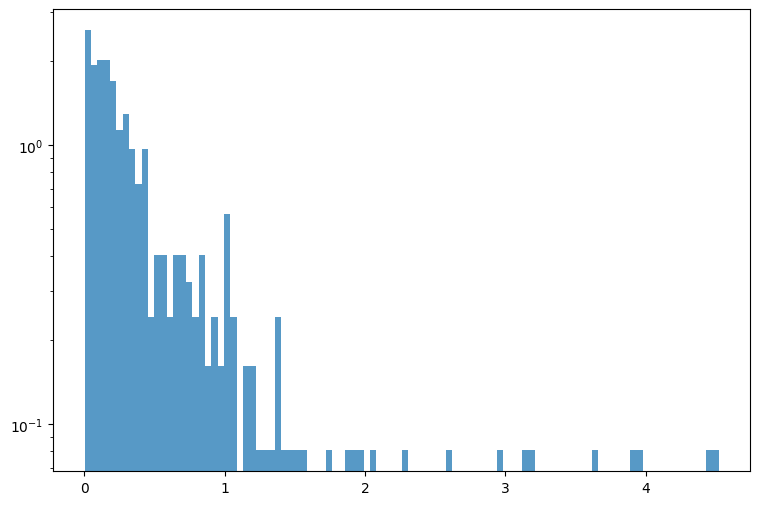

In [ ]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받음
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그림
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [ ]:
# mae_loss가 3 이상으로 동떨어진 샘플이 보임

In [ ]:
import copy

test_df = copy.deepcopy(data_df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 3
test_df.loc[test_df.Loss>threshold]

,time,cargo,Loss
182,2016-01-01,970139,4.520687
183,2016-02-01,845055,3.651311
184,2016-03-01,978233,4.439951
185,2016-04-01,929163,3.967962
186,2016-05-01,950769,3.888204
187,2016-06-01,887044,3.132347
188,2016-07-01,958074,3.165395


In [ ]:
# 기준치를 더 낮춰서 보다 많은 이상치 찾음
threshold = 0.3
test_df.loc[test_df.Loss>threshold]

,time,cargo,Loss
0,2000-11-01,34931,0.758125
1,2000-12-01,36593,0.746102
2,2001-01-01,252454,0.669929
3,2001-02-01,236462,0.517147
4,2001-03-01,251589,0.546007
...,...,...,...
268,2023-03-01,1626596,0.434930
269,2023-04-01,1564123,0.924036
270,2023-05-01,1513617,1.326454
271,2023-06-01,1470733,1.539638


In [ ]:
# 그래프를 그려서 이상치 찾음
fig = plt.figure(figsize=(12, 15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('cargo')
plt.plot(test_df.time, test_df.cargo, linewidth=0.5, alpha=0.75, label='cargo')
plt.plot(test_df.time, test_df.cargo, 'or', markevery=[mae_loss>threshold])

ax = fig.add_subplot(312)
ax.set_title('Loss')
plt.plot(test_df.time, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.time, test_df.Loss, 'or', markevery=[mae_loss>threshold])

Error in callback <function _draw_all_if_interactive at 0x7adbd7705e10> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 1200x1500 with 2 Axes>

# 수요예측을 활용한 anomaly detection

In [19]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

In [55]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [58]:
#read data
data = data_df

In [56]:
#infer the frequency of the data
data = data.asfreq(pd.infer_freq(data.index))

In [57]:
data

,time,cargo
1970-01-01 00:00:00.000000000,NaT,NaN
1970-01-01 00:00:00.000000001,NaT,NaN
1970-01-01 00:00:00.000000002,NaT,NaN
1970-01-01 00:00:00.000000003,NaT,NaN
1970-01-01 00:00:00.000000004,NaT,NaN
...,...,...
1970-01-01 00:00:00.000000279,NaT,NaN
1970-01-01 00:00:00.000000280,NaT,NaN
1970-01-01 00:00:00.000000281,NaT,NaN
1970-01-01 00:00:00.000000282,NaT,NaN


In [59]:
import datetime
idx = pd.IndexSlice

In [60]:
start_date = datetime(2000,01,01)
end_date = datetime(2023,8,1)
data1 = data[start_date:end_date]

SyntaxError: ignored

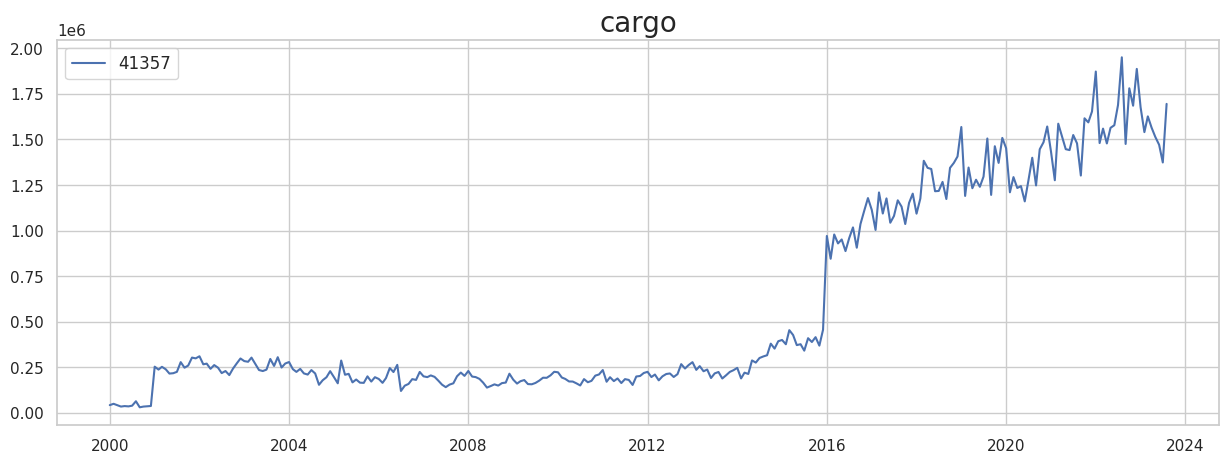

In [61]:
from matplotlib.pylab import rcParams
plt.rcParams["figure.figsize"] = (15,5)
plt.title('cargo', fontsize=20)
plt.plot(data_df.time, data_df.cargo, color='b')
plt.legend(data_df['cargo'], fontsize=12, loc='best')

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

In [62]:
df = data
df = df.rename(columns={'time': 'ds', 'cargo': 'y'})[['ds', 'y']]
df['ds'] =df['ds'].dt.tz_localize(None)
df = df.set_index('ds')
print(df)

                  y
ds                 
2000-01-01    41357
2000-02-01    48615
2000-03-01    41036
2000-04-01    33452
2000-05-01    36137
...             ...
2023-04-01  1564123
2023-05-01  1513617
2023-06-01  1470733
2023-07-01  1373600
2023-08-01  1695185

[284 rows x 1 columns]


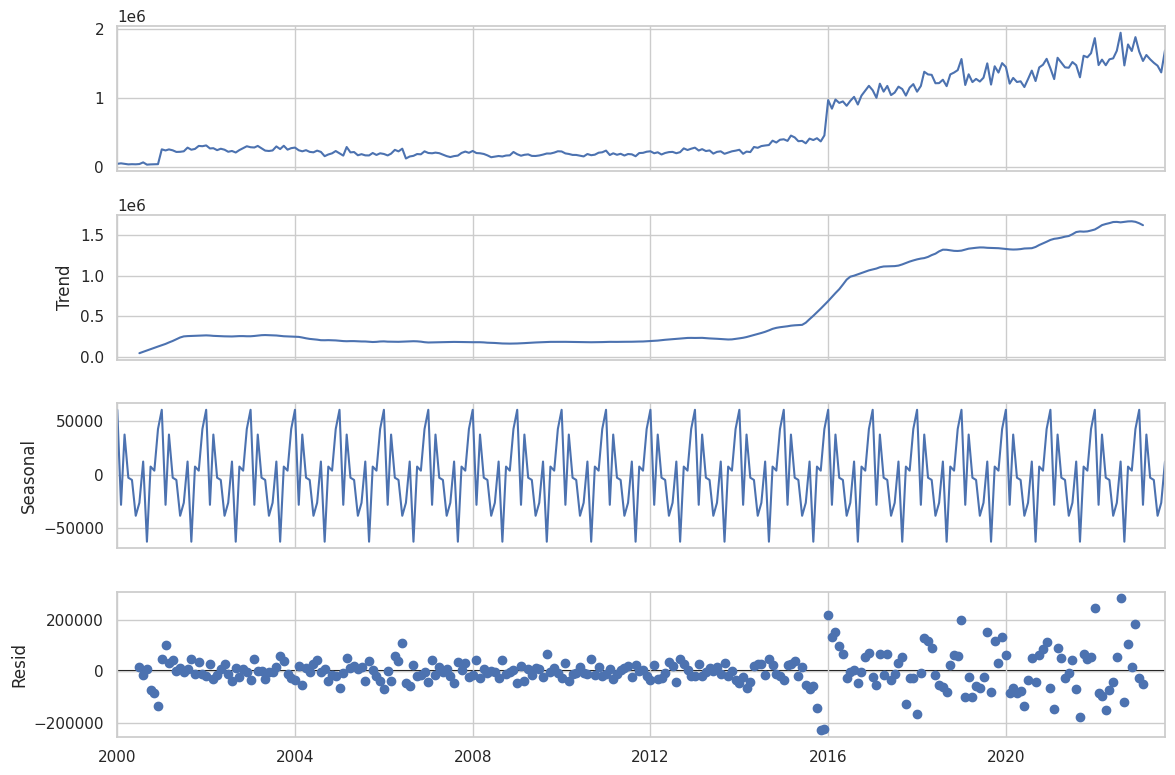

In [63]:
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=15)

result = seasonal_decompose(df, model='additive')
fig = result.plot()

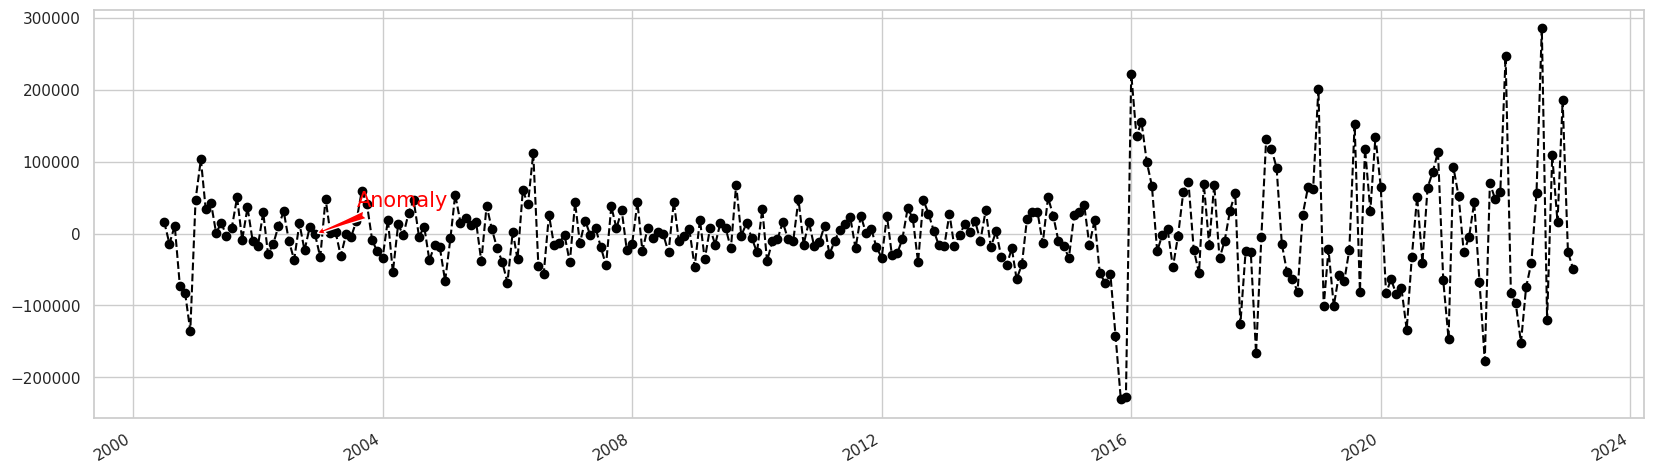

In [65]:
plt.rc('figure',figsize=(20,6))
plt.rc('font',size=15)

fig, ax = plt.subplots()
x = result.resid.index
y = result.resid.values
ax.plot_date(x, y, color='black',linestyle='--')

ax.annotate('Anomaly', (mdates.date2num(x[35]), y[35]), xytext=(30, 20),
           textcoords='offset points', color='red',arrowprops=dict(facecolor='red',arrowstyle='fancy'))

fig.autofmt_xdate()
plt.show()


# isolation forest

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

<Axes: xlabel='ds'>

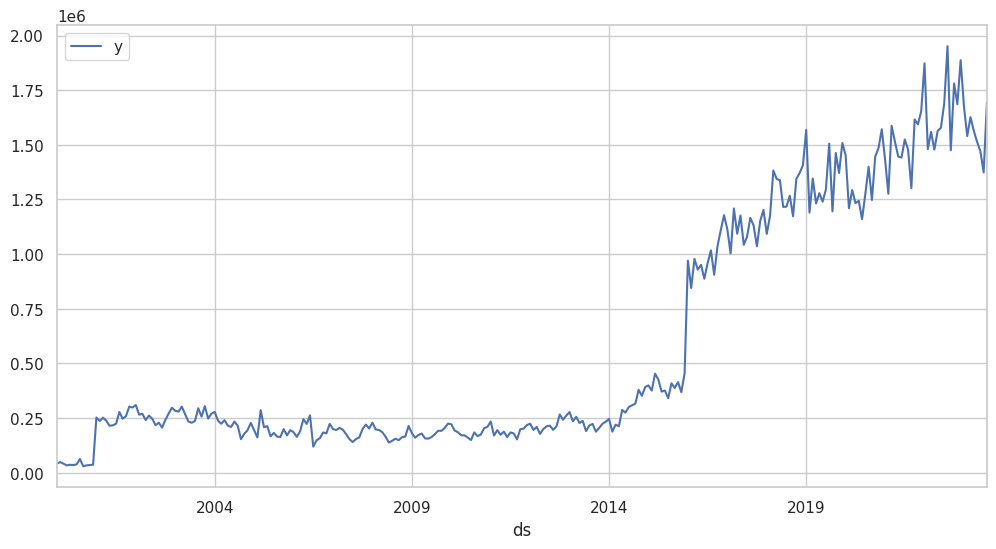

In [68]:
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
df.plot()

In [69]:
outliers_fraction = float(.01)

In [71]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)

In [72]:
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)
IsolationForest(contamination=0.01)

IsolationForest(contamination=0.01)

In [75]:
df

,y,anomaly
ds,,
2000-01-01,41357,1
2000-02-01,48615,1
2000-03-01,41036,1
2000-04-01,33452,1
2000-05-01,36137,1
...,...,...
2023-04-01,1564123,1
2023-05-01,1513617,1
2023-06-01,1470733,1


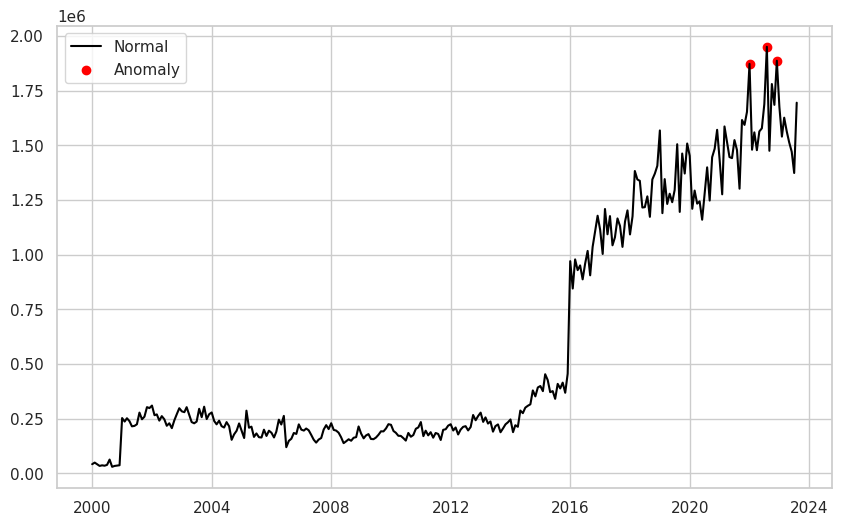

In [76]:
df['anomaly'] = model.predict(data)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly'] == -1, ['y']] #anomaly

ax.plot(df.index, df['y'], color='black', label = 'Normal')
ax.scatter(a.index,a['y'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

# forecasting

In [ ]:
!pip install pmdarima

In [85]:
!pip install pystan~=2.14 # fbprophet 설치
!pip install cmdstanpy>=1.0.4
!pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached ephem-4.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
Failed to build fbprophet
ERROR: Could not build wheels for fbprophet, which is required to install pyproject.toml-based projects


In [ ]:
from fbprophet import Prophet